In [1]:
import datasets
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
ds_uri = 's3://sagemaker-production-eu-central-1-kl-biometric-datasets/raw_datasets/face_biometrics/hackathon_2025-07_camera_fingerprint/'
output_parquet_path = 'output.parquet'

In [4]:
%%time
ds = datasets.load_from_disk(ds_uri)
len(ds)

CPU times: user 2.87 s, sys: 2.17 s, total: 5.04 s
Wall time: 5.93 s


64823

In [5]:
%%time
df = ds.to_pandas()
print(df.shape)
df.head(3)

(64823, 65)
CPU times: user 739 ms, sys: 1.09 s, total: 1.83 s
Wall time: 1.78 s


,img_raw,photo_name,subject_name,session_folder,dataset_name,is_genuine_attempt,is_spoof,attack_type,datacollection_start_timestamp_s,attack_filename,...,browser_name,device_model,device_vendor,os_name,os_version,user_device_camera,split,img_w,img_h,img_wh
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,flavio@keyless.io_flavio@keyless.io-1751283476...,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,web_internal_dc_2025-06-12,True,False,genuine,1.751283e+09,None,...,Chrome,Macintosh,Apple,macOS,10.15.7,flavio@keyless.io___d785486b21be655650933327b9...,train,640,480,640x480


In [6]:
important_columns = [
    'subject_name', 'session_folder', 'photo_name', # user / session / frame ids
    'gif_link', 'file_timestamp_within_session_ms', 'frame_number', # frame info
    'device_metadata', # json string with all the device metadata info
    'camera_device_id', 'camera_label', 'user_device_camera', # camera info parsed from device metadata
    'split', # test / train split
    'os_name', 'os_version', # os info
    'img_w', 'img_h', 'img_wh', # img info
    'img_raw', # jpg bytes of image

]

df[important_columns]

,subject_name,session_folder,photo_name,gif_link,file_timestamp_within_session_ms,frame_number,device_metadata,camera_device_id,camera_label,user_device_camera,split,os_name,os_version,img_w,img_h,img_wh,img_raw
0,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,0.0,0.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,299.0,6.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,599.0,12.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,899.0,18.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,flavio@keyless.io,flavio@keyless.io_1751283476142_1.0.8,flavio@keyless.io_flavio@keyless.io-1751283476...,https://storage.cloud.google.com/kl-cloud-func...,1149.0,23.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",d785486b21be655650933327b9b5295bcfa607f7a879d5...,MacBook Air Camera (0000:0001),flavio@keyless.io___d785486b21be655650933327b9...,train,macOS,10.15.7,640,480,640x480,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64818,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,8800.0,175.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
64819,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,9052.0,180.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
64820,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.com/kl-cloud-func...,9303.0,185.0,"{""media"": {""track"": {""capabilities"": {""aspectR...",1BA7B61A89880176866F8533D603036EB3252C12,Fotocamera anteriore,antonio.epifani@keyless.io___1BA7B61A898801768...,train,iOS,18.5,640,640,640x640,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
64821,antonio.epifani@keyless.io,antonio.epifani@keyless.io_1751372521985_1.0.8,antonio.epifani@keyless.io_antonio.epifani@key...,https://storage.cloud.google.

## Splitted to train/test

In [7]:
df.split.value_counts(dropna=False)

split
train    54143
test     10680
Name: count, dtype: int64

#### Split is done per user:

In [8]:
test_df = df[df.split == 'test']
print(f'test: {test_df.shape}, sessions: {test_df.session_folder.nunique()}, users: {test_df.subject_name.nunique()}')
train_df = df[df.split == 'train']
print(f'train: {train_df.shape}, sessions: {train_df.session_folder.nunique()}, users: {train_df.subject_name.nunique()}')

assert len(set(test_df.subject_name) & set(train_df.subject_name)) == 0

test: (10680, 65), sessions: 279, users: 6
train: (54143, 65), sessions: 1611, users: 46


## Most efficient way how to get session

In [9]:
%%time
def get_session(ds, df, session_folder):
    idx_from_df = df[df.session_folder == selected_session_folder].index.tolist()
    return  ds.select(idx_from_df)

selected_session_folder = df.iloc[100].session_folder
sess_ds = get_session(ds, df, selected_session_folder)
#sess_ds[0]['img_raw']


CPU times: user 24.7 ms, sys: 199 μs, total: 24.9 ms
Wall time: 24 ms


-----

## PRNU Code

In [10]:
import numpy as np
from PIL import Image, ImageFilter



def extract_noise(pil_img):
    img_arr = pil_to_array(pil_img)
    img_arr = center_crop_480(img_arr)
    img_denoised = denoise(pil_img.convert("L"))
    img_denoised = center_crop_480(img_denoised)
    return (img_arr - img_denoised).flatten()


def pil_to_array(pil_img):
    return np.array(pil_img.convert("L")).astype(np.float32) / 255.0


def denoise(pil_image):
    denoised = pil_image.filter(ImageFilter.GaussianBlur(radius=1))
    return np.array(denoised).astype(np.float32) / 255.0


def extract_prnu(pil_images):
    noise_accum = center_crop_480(np.zeros_like(pil_to_array(pil_images[0]))).flatten()
    for img in pil_images:
        noise_accum += extract_noise(img)
    return noise_accum / len(pil_images)

def match_prnu(query_pil, prnu):
    noise = extract_noise(query_pil)
    noise -= noise.mean()
    prnu -= prnu.mean()
    return np.sum(noise * prnu) / (np.linalg.norm(noise) * np.linalg.norm(prnu))


def center_crop_480(img):
    h, w = img.shape[:2]
    top = (h - 480) // 2
    left = (w - 480) // 2
    return img[top:top+480, left:left+480]


prnu_emb = extract_prnu(sess_ds['img_raw'])
print(f'extract prnu: {len(prnu_emb)}')
img_noise = extract_noise(sess_ds[0]['img_raw'])
print(f'extract noise: {len(img_noise)}')

extract prnu: 230400
extract noise: 230400


In [11]:
idx_from_df = df[df.split == 'test'].index.tolist()
test_ds = ds.select(idx_from_df)
# test_df = test_ds.to_pandas()

In [12]:
def add_prnu_noise(row):
    row["prnu_noise"] = extract_noise(row['img_raw'])
    return row

test_ds = test_ds.map(add_prnu_noise, cache_file_name='./tmp_cache/tmp_cache.tmp', num_proc=os.cpu_count()-1)

Map (num_proc=63):   0%|          | 0/10680 [00:00<?, ? examples/s]

In [13]:
test_df = test_ds.to_pandas()
test_df.shape

(10680, 66)

In [14]:
test_df.img_wh.value_counts()

img_wh
480x640    6564
640x480    3925
640x640     120
2x2          71
Name: count, dtype: int64

In [15]:
test_df = test_df[test_df.img_wh != '2x2']

In [16]:
noise_per_sess_df = test_df.groupby('session_folder').agg({'prnu_noise': 'sum', 'photo_name': 'count'}).rename(columns={'photo_name': 'session_size'}).reset_index(drop=False)
noise_per_sess_df.head(3)

,session_folder,prnu_noise,session_size
0,ahmed.atef@keyless.io_1750871273156_1.0.8,"[0.0039215684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",35
1,ahmed.atef@keyless.io_1750871501815_1.0.8,"[0.007843137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",64
2,ahmed.atef@keyless.io_1750871561316_1.0.8,"[-2.05098, -2.7333329, 2.7725487, 0.49411762, ...",55


In [17]:
noise_per_sess_df['embedding'] = noise_per_sess_df.prnu_noise / noise_per_sess_df.session_size
print(noise_per_sess_df.shape)
noise_per_sess_df.head(3)

(278, 4)


,session_folder,prnu_noise,session_size,embedding
0,ahmed.atef@keyless.io_1750871273156_1.0.8,"[0.0039215684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",35,"[0.000112044814, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,ahmed.atef@keyless.io_1750871501815_1.0.8,"[0.007843137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",64,"[0.00012254901, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,ahmed.atef@keyless.io_1750871561316_1.0.8,"[-2.05098, -2.7333329, 2.7725487, 0.49411762, ...",55,"[-0.037290547, -0.04969696, 0.050409976, 0.008..."


In [24]:
display(noise_per_sess_df.embedding.apply(len).value_counts())
assert len(set(noise_per_sess_df.embedding.apply(len))) == 1
assert len(noise_per_sess_df.embedding.iloc[0]) == 480*480

embedding
230400    278
Name: count, dtype: int64

In [25]:
def prnu_similarity(emb1, emb2):
    if emb1.shape != emb2.shape:
        print(f"ERROR different shape {emb1.shape} != {emb2.shape}")
        return 0
    emb1 = emb1.flatten()
    emb2 = emb2.flatten()
    emb1 -= emb1.mean()
    emb2 -= emb2.mean()
    return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))

prnu_similarity(noise_per_sess_df.embedding.iloc[0], noise_per_sess_df.embedding.iloc[1])

0.4369489848613739

In [26]:
# map session to embeddings
emb_map = {row.session_folder: row.embedding for row in noise_per_sess_df[['session_folder', 'embedding']].itertuples()}

----

## Calculate scores matrix

In [27]:
def calculate_scores():
    rows = []

    # cache similar
    scores = {}

    for sess_enroll, enrl_df in tqdm(test_df.groupby('session_folder')):
        for sess_auth, auth_df in test_df.groupby('session_folder'):
            # enrl_imgs = get_session(ds, df, sess_enroll)["img_raw"]
            # auth_imgs = get_session(ds, df, sess_auth)["img_raw"]

            if sess_enroll == sess_auth:
                continue
            
            combo_idx = tuple(sorted([sess_enroll, sess_auth]))
            if combo_idx in scores:
                sim_score = scores[combo_idx]
            else:
                enrl_emb = emb_map[sess_enroll]
                auth_emb = emb_map[sess_auth]
                sim_score = prnu_similarity(enrl_emb, auth_emb)
                scores[combo_idx] = sim_score
            
            enrl_row = enrl_df.iloc[0]
            auth_row = auth_df.iloc[0]

            rows.append({
                'enroll_sess': sess_enroll,
                'auth_sess': sess_auth,

                'enroll_user': enrl_row.subject_name,
                'enroll_camera_label': enrl_row.camera_label,
                'enroll_user_device_camera': enrl_row.user_device_camera,

                'auth_user': auth_row.subject_name,
                'auth_camera_label': auth_row.camera_label,
                'auth_user_device_camera': auth_row.user_device_camera,

                'is_same_user': enrl_row.subject_name == auth_row.subject_name,
                'is_same_camera_label': enrl_row.camera_label == auth_row.camera_label,
                'is_same_user_device_camera': enrl_row.user_device_camera == auth_row.user_device_camera,

                'similarity': sim_score, # This is your score
            })

    return rows

pred_df = pd.DataFrame(calculate_scores())
pred_df.head(3)



  0%|          | 0/278 [00:00<?, ?it/s]

/tmp/ipykernel_18266/2624587164.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_18266/2624587164.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_18266/2624587164.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_18266/2624587164.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_18266/2624587164.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return next(map(float, [np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))]))
/tmp/ipykernel_18266/262458716

,enroll_sess,auth_sess,enroll_user,enroll_camera_label,enroll_user_device_camera,auth_user,auth_camera_label,auth_user_device_camera,is_same_user,is_same_camera_label,is_same_user_device_camera,similarity
0,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871501815_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,True,True,True,0.436949
1,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871561316_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Fantech Luminous C30 (1d6c:1278),ahmed.atef@keyless.io___01d1c987f5595b61ccf52e...,True,False,False,-0.005470
2,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871606693_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Fantech Luminous C30 (1d6c:1278),ahmed.atef@keyless.io___01d1c987f5595b61ccf52e...,True,False,False,-0.001384


In [28]:
%%time
pred_df.to_parquet(output_parquet_path)
print(f'ds {pred_df.shape} saved to "{output_parquet_path}"')

ds (77006, 12) saved to "output.parquet"
CPU times: user 72.9 ms, sys: 36.6 ms, total: 109 ms
Wall time: 107 ms


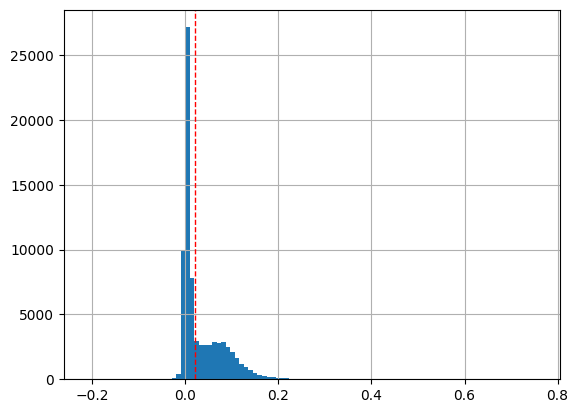

In [29]:
pred_df.similarity.hist(bins=100)
plt.axvline(x=0.02, color='red', linestyle='--', linewidth=1)

In [30]:
def get_FAR_FRR(df, thr=0.5, pred_col='similarity', target_col='is_same_user_device_camera'):
    targets = df[target_col]
    pred_proba = df[pred_col]
    
    preds = pred_proba > thr
    TP = sum((targets == True) & (preds == True))
    FP = sum((targets == False) & (preds == True))
    TN = sum((targets == False) & (preds == False))
    FN = sum((targets == True) & (preds == False))

    FAR = FP / (TN + FP)
    FRR = FN / (TP + FN)

    # print(f'FAR: {FAR:.1%}')
    # print(f'FRR: {FRR:.1%}')
    return FAR, FRR


In [31]:

fars = []
frrs = []
for t in np.arange(0, 1, 0.01):
    far, frr = get_FAR_FRR(pred_df, t)
    fars.append(far)
    frrs.append(frr)




In [32]:
def get_closest_to_far(target_far, fars, frrs):
    idx = (np.array(fars) < target_far).argmax()
    return fars[idx], frrs[idx]

def get_closest_to_frr(target_frr, fars, frrs):
    idx = (np.array(frrs) > target_frr).argmax()
    print(idx)
    return fars[idx], frrs[idx]

2


Text(0.5, 1.0, '8.2% FRR @ 9.0% FAR')

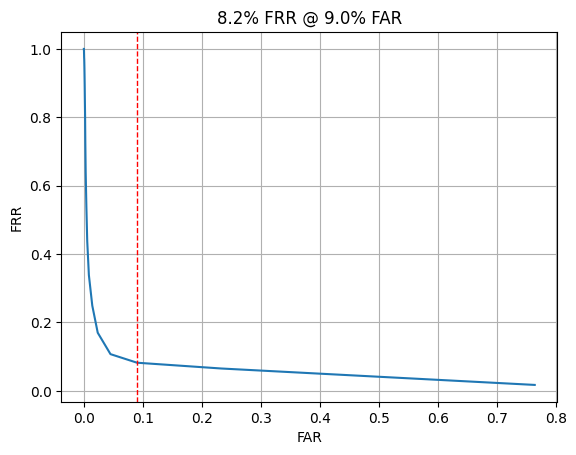

In [35]:

target_frr = 0.08
sel_far, sel_frr = get_closest_to_frr(target_frr, fars, frrs)

plt.plot(fars, frrs)
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.grid()
plt.axvline(x=sel_far, color='red', linestyle='--', linewidth=1)
plt.title(f'{sel_frr:.1%} FRR @ {sel_far:.1%} FAR')